# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


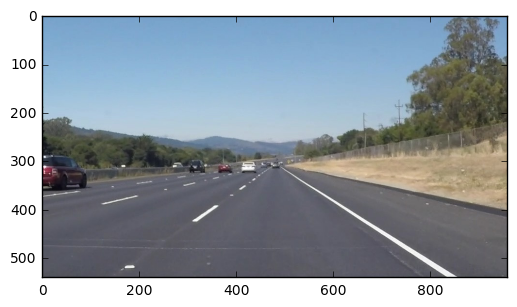

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def clear_global():

    global save_x1
    global save_y1
    global save_x2    
    global save_y2
    global save_x1_1
    global save_y1_1
    global save_x2_1    
    global save_y2_1
    
    save_x1 = list()
    save_y1 = list()
    save_x2 = list()
    save_y2 = list()
    save_x1_1 = list()
    save_y1_1 = list()
    save_x2_1 = list()
    save_y2_1 = list()
    
    return

def shadow_remover(img):
    
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(img)
    
    return fgmask

def gray_scaled(img):
    """Applies the equilized gray scale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    return cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def yellowgrayscale(img):
    #enhance yellow then find grayscale
        
    #RGB limits
    lower = np.array([80,80,40])
    upper = np.array([255,255,80])
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(img, lower, upper)
    #show_image('mask',mask)
 
    # Bitwise-AND mask and original image
    gray_image = cv2.bitwise_and(img, img, mask= mask)
    gray_image = cv2.addWeighted(gray_image, 1.0, img, 1.0, 0)  
    gray_image = gray_scaled(gray_image)
    gray_image = cv2.equalizeHist(gray_image)
    
    return gray_image
    

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def drawline_1(img, x1, y1, x2, y2):
    global save_x1_1
    global save_y1_1
    global save_x2_1  
    global save_y2_1
    
    save_x1_1.append(x1)
    save_y1_1.append(y1)
    save_x2_1.append(x2)
    save_y2_1.append(y2)
    if len(save_x1_1)>6:
        save_x1_1.pop(0)
        save_y1_1.pop(0)
        save_x2_1.pop(0)
        save_y2_1.pop(0)
        cv2.line(img,(int(np.mean(save_x1_1)),int(np.mean(save_y1_1))),(int(np.mean(save_x2_1)),int(np.mean(save_y2_1))),(255,0,0),10)
    else:
        cv2.line(img,(x1,y1),(x2,y2),(255,255,0),10)
    
    return img

def drawline_0(img, x1, y1, x2, y2):
    global save_x1
    global save_y1
    global save_x2    
    global save_y2
    
    save_x1.append(x1)
    save_y1.append(y1)
    save_x2.append(x2)
    save_y2.append(y2)
    if len(save_x1)>6:
        save_x1.pop(0)
        save_y1.pop(0)
        save_x2.pop(0)
        save_y2.pop(0)
        cv2.line(img,(int(np.mean(save_x1)),int(np.mean(save_y1))),(int(np.mean(save_x2)),int(np.mean(save_y2))),(255,0,0),10)
    else:
        cv2.line(img,(x1,y1),(x2,y2),(255,255,0),10)
    
    
    return img
    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

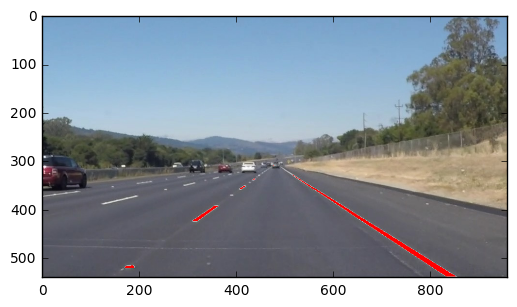

In [5]:
#Basic road marking detection 101 for reference: using color selection, and region of interest

# Read in the image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Grab the x and y sizes and make two copies of the image
# With one copy we'll extract only the pixels that meet our selection,
# then we'll paint those pixels red in the original image to see our selection 
# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a triangle region of interest (Note: if you run this code, 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz ;)
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [480, 300]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Perform a "bitwise or" to mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
# Mask color selection
color_select[color_thresholds] = [0,0,0]
# Find where image is both colored right and in the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

# Display our two output images
plt.imshow(color_select)
plt.imshow(line_image)

In [6]:
#Basic road marking detection 102: using canny edge and hough transform, along with region of interest

def pipeline(image):

    # Convert to Yellow Enhanced Grayscale
    gray = yellowgrayscale(img=image)
    
    #####################Parameters#########################

    # Define parameters for Canny and run it....50..150
    low_threshold = 500
    high_threshold = 500

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(30,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid....2
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)....15
    min_line_length = 30 #minimum number of pixels making up a line....40
    max_line_gap = 45 # maximum gap in pixels between connectable line segments...20
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    #####################Pipeline#########################
    
    # Masked Edges
    edges = canny(gray, low_threshold, high_threshold)  
    
    # Region of Interest
    masked_edges = region_of_interest(edges, vertices)    

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
        
    # Initial points hardcoded
    primary_x_l = 0
    primary_y_l = 0
    length_lead_line = 0
    
    sum_slope_l = 0
    sum_slope_r = 0
    count_line_l = 0
    count_line_r = 0
    
    primary_x_r = 0
    primary_y_r = 0
    length_lead_line_l = 0
    length_lead_line_r = 0
    
    lower_left_y = imshape[0]
    lower_right_y = imshape[0]
    upper_left_y = int(imshape[0]*0.6)
    upper_right_y = int(imshape[0]*0.6)
    
    # FindLines
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))            
            if slope > -0.8 and slope < -0.6:
                
                sum_slope_l = slope + sum_slope_l
                count_line_l = count_line_l + 1
                 
                length_lead_line_update_l = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                
                if length_lead_line_l <= length_lead_line_update_l:
                    length_lead_line_l = length_lead_line_update_l 
                    primary_x_l = x2
                    primary_y_l = y2
                
            elif slope <0.70 and slope >0.50:
                sum_slope_r = slope + sum_slope_r
                count_line_r = count_line_r + 1
                 
                length_lead_line_update_r = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                
                if length_lead_line_r <= length_lead_line_update_r:
                    length_lead_line_r = length_lead_line_update_r
                    primary_x_r = x2
                    primary_y_r = y2
             
    #Correcting bottom intercept_l
    left_c = primary_y_l - (sum_slope_l/count_line_l)*primary_x_l  
    lower_left_x = int((lower_left_y - left_c)/(sum_slope_l/count_line_l))
    upper_left_x = int((upper_left_y - left_c)/(sum_slope_l/count_line_l))
    
    #Correcting bottom intercept_r
    right_c = primary_y_r - (sum_slope_r/count_line_r)*primary_x_r   
    lower_right_x = int((lower_right_y - right_c)/(sum_slope_r/count_line_r))
    upper_right_x = int((upper_right_y - right_c)/(sum_slope_r/count_line_r))
    
    # Draw the lines on the edge image
    line_image = drawline_0(line_image, lower_left_x, lower_left_y, upper_left_x, upper_left_y)
    line_image = drawline_1(line_image, lower_right_x, lower_right_y, upper_right_x, upper_right_y)
    lines_edges = weighted_img(line_image,image, 0.8,  1, 0) 
    
    return lines_edges

In [7]:
 #coefficients = np.polyfit(array_l[:,0], array_l[:,1], 1) 
    #polynomial = np.poly1d(coefficients)
    #ys = polynomial(array_l[:,0])
    
    #line_plot = plt.plot(array_l[:,0], ys)

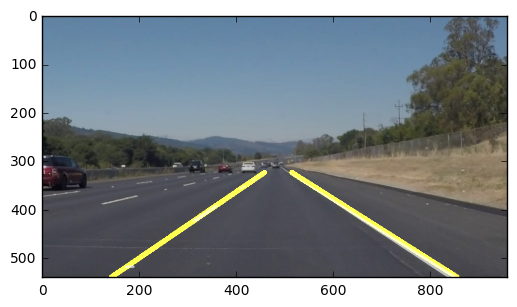

In [8]:
# Test Functions here... 
test1 = mpimg.imread('test_images/solidWhiteRight.jpg')
clear_global()
plt.imshow(pipeline(test1))

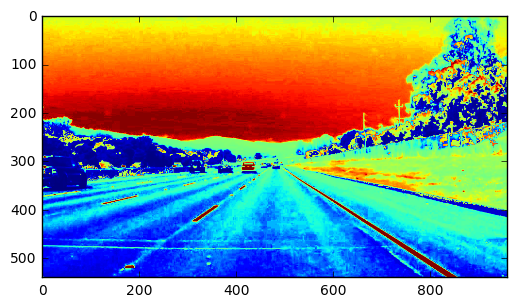

In [9]:
    # Test Shadow Remover here:
    image = mpimg.imread('test_images/solidWhiteRight.jpg')
    

    # Convert to Yellow Enhanced Grayscale
    gray = yellowgrayscale(img=image)
    
    #####################Parameters#########################

    # Define parameters for Canny and run it
    low_threshold = 500
    high_threshold = 500

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define mask ignore color for Masked Edges
    #ignore_mask_color = 255
    
    
    # Defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 40 # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    #####################Pipeline#########################
    
    # Masked Edges
    edges = canny(gray, low_threshold, high_threshold)   
    
    # Region of Interest
    masked_edges = region_of_interest(edges, vertices)    

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image, (x1,y1),(x2,y2),(255,255,0),10)

    plt.imshow(gray)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):    
    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
clear_global()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.59 s, sys: 571 ms, total: 4.17 s
Wall time: 6.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
clear_global()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:20<00:00, 33.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.3 s, sys: 1.52 s, total: 13.8 s
Wall time: 21 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In [16]:
# My lane finding pipeline:
# - Applied an equalized grayscale transform, Applied CannyEdge Detection + Hough Transform
# - Classified line segements as left line and right line based on slope
# - Extrapolated the longest line segment on either side per frame - by calculating intercept and finding top and bottom coordinates
# - Moving average accross frames to reduce jitter

#How will I make it better and more robust:
# - Use higher-order polynonomial fit instead of one straight line to draw curved lines in OpenCV
# - Improve shadow / noise handling by playing with threshold values, and potentially changing to  HSV space
# - Exploring BackgroundSubtractorMOG

#Where is it likely to fail:
# - Slope of line diviates beyond hard coded limits
# - Zero lines in slope limits will error out as average slope will not be calculated
# - Deviation in video quality / camera angles / lane types / shadows / etc. 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:14<00:00, 16.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.39 s, sys: 1.63 s, total: 11 s
Wall time: 16.4 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))